In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import sys

In [2]:
sys.path.append('../')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import json

import phononet as pn

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1571.69it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
from tensorflow import keras

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
import numpy as np

In [10]:
X_train=train.X.numpy()
y_train=np.array(train.y)[...,np.newaxis]

X_val=test.X.numpy()
y_val=np.array(test.y)[...,np.newaxis]

In [11]:
X_train.shape,y_train.shape

((2437, 12, 1500), (2437, 1))

In [12]:
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000).batch(32)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(32)

In [13]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, size, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(**kwargs) # handles base args (e.g., dtype)
        self.size=size
        self.total_cm = self.add_weight("total", shape=(size,size), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.size)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    


In [14]:
class MySequential(keras.Sequential):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [15]:
from tensorflow.keras.models import Sequential

In [28]:
model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    keras.layers.BatchNormalization(name='bn0',axis=[3]),
    #
    keras.layers.Conv2D(64,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2)),
    keras.layers.Dropout(.2),
    #
    keras.layers.Conv2D(128,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn2',axis=[3]),
    keras.layers.MaxPool2D((1,3)),
    keras.layers.Dropout(.2),
    #
    keras.layers.Conv2D(150,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn3',axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    keras.layers.Dropout(.2),
    #
    keras.layers.Conv2D(200,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(30)

])

model.summary()

Model: "my_sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 12, 1500, 1)       0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 12, 1500, 1)       4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 1500, 64)      640       
_________________________________________________________________
activation_7 (Activation)    (None, 12, 1500, 64)      0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 1500, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 750, 64)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 750, 64)   

In [29]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [30]:
history=model.fit(train_data,validation_data=val_data,epochs=100)

Epoch 1/100
77/77 [==============================] - 14s 178ms/step - loss: 3.2606 - accuracy: 0.1211 - F1_0: 0.0819 - F1_1: 0.0485 - F1_2: 0.0000e+00 - F1_3: 0.1270 - F1_4: 0.0873 - F1_5: 0.1084 - F1_6: 0.0047 - F1_7: 0.0185 - F1_8: 0.0484 - F1_9: 0.0779 - F1_10: 0.2112 - F1_11: 0.0165 - F1_12: 0.0165 - F1_13: 0.0360 - F1_14: 0.1055 - F1_15: 0.0315 - F1_16: 0.0587 - F1_17: 0.0039 - F1_18: 0.0057 - F1_19: 0.0462 - F1_20: 0.0888 - F1_21: 0.0020 - F1_22: 0.0393 - F1_23: 0.0692 - F1_24: 0.0652 - F1_25: 0.0486 - F1_26: 0.1961 - F1_27: 0.0634 - F1_28: 0.1356 - F1_29: 0.0741 - val_loss: 5.3040 - val_accuracy: 0.0556 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.1163 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - val_F1_16:

77/77 [==============================] - 13s 167ms/step - loss: 1.3481 - accuracy: 0.6795 - F1_0: 0.4168 - F1_1: 0.5300 - F1_2: 0.3755 - F1_3: 0.6260 - F1_4: 0.8152 - F1_5: 0.6534 - F1_6: 0.7876 - F1_7: 0.6931 - F1_8: 0.7586 - F1_9: 0.5130 - F1_10: 0.6934 - F1_11: 0.1024 - F1_12: 0.6325 - F1_13: 0.6341 - F1_14: 0.6314 - F1_15: 0.6512 - F1_16: 0.6893 - F1_17: 0.2389 - F1_18: 0.3660 - F1_19: 0.7398 - F1_20: 0.7524 - F1_21: 0.6823 - F1_22: 0.7089 - F1_23: 0.5684 - F1_24: 0.4949 - F1_25: 0.7362 - F1_26: 0.7288 - F1_27: 0.6473 - F1_28: 0.5749 - F1_29: 0.5865 - val_loss: 3.2084 - val_accuracy: 0.1866 - val_F1_0: 0.1053 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2632 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0556 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1667 - val_F1_8: 0.5294 - val_F1_9: 0.0952 - val_F1_10: 0.0526 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.5128 - val_F1_15: 0.4706 - val_F1_16: 0.4324 - val_F1_17: 0.3310 - val_F1_18: 0.1600 

Epoch 14/100
77/77 [==============================] - 13s 167ms/step - loss: 0.4776 - accuracy: 0.9040 - F1_0: 0.9178 - F1_1: 0.7847 - F1_2: 0.8036 - F1_3: 0.8940 - F1_4: 0.8544 - F1_5: 0.8841 - F1_6: 0.9229 - F1_7: 0.8878 - F1_8: 0.9457 - F1_9: 0.9083 - F1_10: 0.8997 - F1_11: 0.6485 - F1_12: 0.9080 - F1_13: 0.7930 - F1_14: 0.9147 - F1_15: 0.9317 - F1_16: 0.8487 - F1_17: 0.8297 - F1_18: 0.6413 - F1_19: 0.8793 - F1_20: 0.9371 - F1_21: 0.8795 - F1_22: 0.8925 - F1_23: 0.9255 - F1_24: 0.8892 - F1_25: 0.8630 - F1_26: 0.9460 - F1_27: 0.8378 - F1_28: 0.8208 - F1_29: 0.8831 - val_loss: 2.6316 - val_accuracy: 0.3091 - val_F1_0: 0.1935 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5833 - val_F1_4: 0.2083 - val_F1_5: 0.0000e+00 - val_F1_6: 0.1818 - val_F1_7: 0.1538 - val_F1_8: 0.5600 - val_F1_9: 0.2236 - val_F1_10: 0.1951 - val_F1_11: 0.5714 - val_F1_12: 0.7324 - val_F1_13: 0.2222 - val_F1_14: 0.6667 - val_F1_15: 0.2500 - val_F1_16: 0.7368 - val_F1_17: 0.1143 - val_F1_18: 0.4242 - v

Epoch 21/100
77/77 [==============================] - 13s 167ms/step - loss: 0.2487 - accuracy: 0.9602 - F1_0: 0.9205 - F1_1: 0.9485 - F1_2: 0.8623 - F1_3: 0.9711 - F1_4: 0.9629 - F1_5: 0.9861 - F1_6: 0.9833 - F1_7: 0.9092 - F1_8: 0.8985 - F1_9: 0.9484 - F1_10: 0.9890 - F1_11: 0.8856 - F1_12: 0.9244 - F1_13: 0.8048 - F1_14: 0.9796 - F1_15: 0.9618 - F1_16: 0.9156 - F1_17: 0.9487 - F1_18: 0.9358 - F1_19: 0.9793 - F1_20: 0.9736 - F1_21: 0.9516 - F1_22: 0.9044 - F1_23: 0.9853 - F1_24: 0.9651 - F1_25: 0.9618 - F1_26: 0.9870 - F1_27: 0.9799 - F1_28: 0.9693 - F1_29: 0.9072 - val_loss: 2.8691 - val_accuracy: 0.3832 - val_F1_0: 0.4314 - val_F1_1: 0.2778 - val_F1_2: 0.4651 - val_F1_3: 0.6182 - val_F1_4: 0.5806 - val_F1_5: 0.0000e+00 - val_F1_6: 0.2105 - val_F1_7: 0.0000e+00 - val_F1_8: 0.3810 - val_F1_9: 0.2759 - val_F1_10: 0.0625 - val_F1_11: 0.4865 - val_F1_12: 0.5854 - val_F1_13: 0.3636 - val_F1_14: 0.4000 - val_F1_15: 0.4681 - val_F1_16: 0.3429 - val_F1_17: 0.1515 - val_F1_18: 0.4444 - val_F

Epoch 28/100
77/77 [==============================] - 13s 167ms/step - loss: 0.1462 - accuracy: 0.9729 - F1_0: 0.9527 - F1_1: 0.9337 - F1_2: 0.9303 - F1_3: 0.9610 - F1_4: 0.9139 - F1_5: 0.9762 - F1_6: 0.9996 - F1_7: 0.8780 - F1_8: 0.9829 - F1_9: 0.9702 - F1_10: 0.9739 - F1_11: 0.9945 - F1_12: 0.9495 - F1_13: 0.8663 - F1_14: 0.9215 - F1_15: 0.9925 - F1_16: 0.8829 - F1_17: 0.9872 - F1_18: 0.9939 - F1_19: 0.9342 - F1_20: 0.9852 - F1_21: 0.9755 - F1_22: 0.9765 - F1_23: 0.9619 - F1_24: 0.9742 - F1_25: 0.9897 - F1_26: 0.9897 - F1_27: 0.9450 - F1_28: 0.9829 - F1_29: 0.9664 - val_loss: 2.8625 - val_accuracy: 0.4131 - val_F1_0: 0.3171 - val_F1_1: 0.0000e+00 - val_F1_2: 0.2963 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4407 - val_F1_5: 0.0526 - val_F1_6: 0.0741 - val_F1_7: 0.2000 - val_F1_8: 0.5714 - val_F1_9: 0.3810 - val_F1_10: 0.5581 - val_F1_11: 0.1818 - val_F1_12: 0.8101 - val_F1_13: 0.2667 - val_F1_14: 0.0800 - val_F1_15: 0.9167 - val_F1_16: 0.5000 - val_F1_17: 0.3973 - val_F1_18: 0.5806 - val_F

Epoch 35/100
77/77 [==============================] - 13s 167ms/step - loss: 0.1232 - accuracy: 0.9795 - F1_0: 0.9471 - F1_1: 0.9663 - F1_2: 0.9967 - F1_3: 0.9964 - F1_4: 0.9264 - F1_5: 0.9426 - F1_6: 0.9857 - F1_7: 0.8733 - F1_8: 0.9843 - F1_9: 0.9874 - F1_10: 0.8919 - F1_11: 0.9632 - F1_12: 0.9782 - F1_13: 0.9887 - F1_14: 0.9708 - F1_15: 0.9840 - F1_16: 0.9644 - F1_17: 1.0000 - F1_18: 0.8821 - F1_19: 0.9355 - F1_20: 0.9875 - F1_21: 0.9744 - F1_22: 0.9611 - F1_23: 0.9752 - F1_24: 0.9268 - F1_25: 0.9906 - F1_26: 0.9776 - F1_27: 0.9723 - F1_28: 0.9983 - F1_29: 0.9754 - val_loss: 4.7060 - val_accuracy: 0.3020 - val_F1_0: 0.0690 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.3830 - val_F1_4: 0.1111 - val_F1_5: 0.4483 - val_F1_6: 0.0000e+00 - val_F1_7: 0.4000 - val_F1_8: 0.0000e+00 - val_F1_9: 0.4516 - val_F1_10: 0.3590 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0476 - val_F1_13: 0.5714 - val_F1_14: 0.4375 - val_F1_15: 0.0000e+00 - val_F1_16: 0.2000 - val_F1_17: 0.0000e+00 - val_F

Epoch 42/100
77/77 [==============================] - 13s 167ms/step - loss: 0.0854 - accuracy: 0.9852 - F1_0: 0.9684 - F1_1: 0.9809 - F1_2: 0.9850 - F1_3: 0.9707 - F1_4: 0.9819 - F1_5: 0.8999 - F1_6: 0.9946 - F1_7: 0.9686 - F1_8: 0.9856 - F1_9: 0.9743 - F1_10: 0.9609 - F1_11: 0.9415 - F1_12: 0.9910 - F1_13: 0.9231 - F1_14: 0.9769 - F1_15: 1.0000 - F1_16: 0.9603 - F1_17: 0.9615 - F1_18: 0.7643 - F1_19: 0.9951 - F1_20: 0.9922 - F1_21: 0.9769 - F1_22: 0.9814 - F1_23: 0.9691 - F1_24: 0.9950 - F1_25: 0.9665 - F1_26: 0.9988 - F1_27: 0.9423 - F1_28: 0.9744 - F1_29: 1.0000 - val_loss: 2.7072 - val_accuracy: 0.4202 - val_F1_0: 0.3902 - val_F1_1: 0.0784 - val_F1_2: 0.0930 - val_F1_3: 0.4524 - val_F1_4: 0.2963 - val_F1_5: 0.1765 - val_F1_6: 0.3226 - val_F1_7: 0.2353 - val_F1_8: 0.5714 - val_F1_9: 0.2500 - val_F1_10: 0.4681 - val_F1_11: 0.1818 - val_F1_12: 0.7901 - val_F1_13: 0.3333 - val_F1_14: 0.3889 - val_F1_15: 0.6000 - val_F1_16: 0.7000 - val_F1_17: 0.4390 - val_F1_18: 0.4375 - val_F1_19: 0.

Epoch 49/100
77/77 [==============================] - 13s 167ms/step - loss: 0.0667 - accuracy: 0.9885 - F1_0: 0.9708 - F1_1: 0.9801 - F1_2: 0.9957 - F1_3: 0.9877 - F1_4: 0.9912 - F1_5: 0.9758 - F1_6: 0.9833 - F1_7: 0.9849 - F1_8: 0.9921 - F1_9: 0.9825 - F1_10: 0.9772 - F1_11: 0.9461 - F1_12: 0.9878 - F1_13: 0.9487 - F1_14: 0.9990 - F1_15: 0.9947 - F1_16: 0.9798 - F1_17: 0.9872 - F1_18: 0.9013 - F1_19: 0.9219 - F1_20: 0.9921 - F1_21: 0.9949 - F1_22: 0.9742 - F1_23: 0.9451 - F1_24: 0.9962 - F1_25: 1.0000 - F1_26: 0.9930 - F1_27: 0.9852 - F1_28: 1.0000 - F1_29: 0.9859 - val_loss: 3.4279 - val_accuracy: 0.4117 - val_F1_0: 0.5128 - val_F1_1: 0.4286 - val_F1_2: 0.2290 - val_F1_3: 0.6538 - val_F1_4: 0.5926 - val_F1_5: 0.0000e+00 - val_F1_6: 0.1905 - val_F1_7: 0.0000e+00 - val_F1_8: 0.4898 - val_F1_9: 0.1600 - val_F1_10: 0.0000e+00 - val_F1_11: 0.4390 - val_F1_12: 0.6667 - val_F1_13: 0.4000 - val_F1_14: 0.6316 - val_F1_15: 0.8889 - val_F1_16: 0.4828 - val_F1_17: 0.3978 - val_F1_18: 0.4444 - v

Epoch 56/100
77/77 [==============================] - 13s 168ms/step - loss: 0.0979 - accuracy: 0.9811 - F1_0: 0.9582 - F1_1: 0.9798 - F1_2: 0.9191 - F1_3: 0.9842 - F1_4: 0.9888 - F1_5: 0.9872 - F1_6: 0.9964 - F1_7: 0.9714 - F1_8: 0.9385 - F1_9: 0.9715 - F1_10: 0.9816 - F1_11: 0.9659 - F1_12: 0.8913 - F1_13: 0.9103 - F1_14: 0.9947 - F1_15: 0.9421 - F1_16: 0.9655 - F1_17: 0.9744 - F1_18: 0.9917 - F1_19: 0.9755 - F1_20: 0.9736 - F1_21: 0.9784 - F1_22: 0.9797 - F1_23: 0.9688 - F1_24: 0.9819 - F1_25: 0.9932 - F1_26: 0.9853 - F1_27: 0.9501 - F1_28: 1.0000 - F1_29: 0.9496 - val_loss: 3.3610 - val_accuracy: 0.4017 - val_F1_0: 0.3810 - val_F1_1: 0.3077 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2632 - val_F1_4: 0.7500 - val_F1_5: 0.3099 - val_F1_6: 0.0000e+00 - val_F1_7: 0.3636 - val_F1_8: 0.5385 - val_F1_9: 0.5263 - val_F1_10: 0.3793 - val_F1_11: 0.2581 - val_F1_12: 0.0500 - val_F1_13: 0.5455 - val_F1_14: 0.8000 - val_F1_15: 0.2857 - val_F1_16: 0.4000 - val_F1_17: 0.2000 - val_F1_18: 0.6522 - val_F

Epoch 63/100
77/77 [==============================] - 13s 168ms/step - loss: 0.0357 - accuracy: 0.9947 - F1_0: 0.9776 - F1_1: 0.9851 - F1_2: 1.0000 - F1_3: 0.9787 - F1_4: 0.9929 - F1_5: 1.0000 - F1_6: 0.9872 - F1_7: 0.9983 - F1_8: 0.9856 - F1_9: 1.0000 - F1_10: 0.9996 - F1_11: 0.9865 - F1_12: 1.0000 - F1_13: 0.9359 - F1_14: 0.9771 - F1_15: 1.0000 - F1_16: 0.9756 - F1_17: 0.9615 - F1_18: 0.9573 - F1_19: 1.0000 - F1_20: 0.9884 - F1_21: 0.9487 - F1_22: 1.0000 - F1_23: 0.9994 - F1_24: 1.0000 - F1_25: 0.9744 - F1_26: 0.9968 - F1_27: 0.9876 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 2.3362 - val_accuracy: 0.4829 - val_F1_0: 0.3441 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2564 - val_F1_4: 0.5532 - val_F1_5: 0.0000e+00 - val_F1_6: 0.3125 - val_F1_7: 0.2353 - val_F1_8: 0.6000 - val_F1_9: 0.6800 - val_F1_10: 0.7273 - val_F1_11: 0.3333 - val_F1_12: 0.7541 - val_F1_13: 0.6667 - val_F1_14: 0.5500 - val_F1_15: 0.5882 - val_F1_16: 0.4118 - val_F1_17: 0.4381 - val_F1_18: 0.4000 - v

Epoch 70/100
77/77 [==============================] - 13s 168ms/step - loss: 0.0635 - accuracy: 0.9881 - F1_0: 0.9861 - F1_1: 0.9587 - F1_2: 1.0000 - F1_3: 0.9926 - F1_4: 0.9926 - F1_5: 1.0000 - F1_6: 0.9977 - F1_7: 0.9647 - F1_8: 0.9842 - F1_9: 0.9820 - F1_10: 0.9906 - F1_11: 0.9719 - F1_12: 1.0000 - F1_13: 0.9793 - F1_14: 0.9381 - F1_15: 0.9854 - F1_16: 0.9982 - F1_17: 0.9202 - F1_18: 0.9171 - F1_19: 0.9761 - F1_20: 0.9854 - F1_21: 0.9292 - F1_22: 0.9893 - F1_23: 0.9844 - F1_24: 0.9629 - F1_25: 0.9077 - F1_26: 0.9943 - F1_27: 0.9818 - F1_28: 0.9599 - F1_29: 1.0000 - val_loss: 3.1374 - val_accuracy: 0.4544 - val_F1_0: 0.4444 - val_F1_1: 0.0833 - val_F1_2: 0.0000e+00 - val_F1_3: 0.6154 - val_F1_4: 0.3158 - val_F1_5: 0.2703 - val_F1_6: 0.2000 - val_F1_7: 0.2222 - val_F1_8: 0.6486 - val_F1_9: 0.3750 - val_F1_10: 0.5965 - val_F1_11: 0.2400 - val_F1_12: 0.8267 - val_F1_13: 0.2963 - val_F1_14: 0.5357 - val_F1_15: 0.4314 - val_F1_16: 0.6154 - val_F1_17: 0.4228 - val_F1_18: 0.3077 - val_F1_19

Epoch 77/100
77/77 [==============================] - 13s 167ms/step - loss: 0.0226 - accuracy: 0.9963 - F1_0: 1.0000 - F1_1: 0.9974 - F1_2: 0.9872 - F1_3: 0.9951 - F1_4: 0.9808 - F1_5: 0.9841 - F1_6: 1.0000 - F1_7: 0.9615 - F1_8: 0.9969 - F1_9: 0.9944 - F1_10: 1.0000 - F1_11: 0.9984 - F1_12: 1.0000 - F1_13: 0.9487 - F1_14: 0.9873 - F1_15: 0.9744 - F1_16: 0.9843 - F1_17: 0.9834 - F1_18: 1.0000 - F1_19: 0.9615 - F1_20: 0.9992 - F1_21: 0.9487 - F1_22: 0.9864 - F1_23: 0.9685 - F1_24: 1.0000 - F1_25: 0.9872 - F1_26: 1.0000 - F1_27: 0.9973 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 2.6962 - val_accuracy: 0.4672 - val_F1_0: 0.4211 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0588 - val_F1_3: 0.6197 - val_F1_4: 0.5600 - val_F1_5: 0.1951 - val_F1_6: 0.1333 - val_F1_7: 0.2857 - val_F1_8: 0.5366 - val_F1_9: 0.4878 - val_F1_10: 0.6122 - val_F1_11: 0.0952 - val_F1_12: 0.8533 - val_F1_13: 0.5714 - val_F1_14: 0.5306 - val_F1_15: 0.8571 - val_F1_16: 0.4000 - val_F1_17: 0.2745 - val_F1_18: 0.3016 - val_F1_19

Epoch 84/100
77/77 [==============================] - 13s 167ms/step - loss: 0.0337 - accuracy: 0.9934 - F1_0: 1.0000 - F1_1: 0.9698 - F1_2: 1.0000 - F1_3: 0.9948 - F1_4: 0.9872 - F1_5: 1.0000 - F1_6: 0.9945 - F1_7: 1.0000 - F1_8: 0.9834 - F1_9: 1.0000 - F1_10: 0.9533 - F1_11: 0.8833 - F1_12: 0.9615 - F1_13: 0.9872 - F1_14: 1.0000 - F1_15: 0.9955 - F1_16: 0.9706 - F1_17: 0.9772 - F1_18: 0.9359 - F1_19: 1.0000 - F1_20: 0.9993 - F1_21: 1.0000 - F1_22: 0.9440 - F1_23: 1.0000 - F1_24: 0.9379 - F1_25: 0.9832 - F1_26: 1.0000 - F1_27: 0.9573 - F1_28: 0.9823 - F1_29: 0.9992 - val_loss: 3.1593 - val_accuracy: 0.4601 - val_F1_0: 0.4324 - val_F1_1: 0.1000 - val_F1_2: 0.0000e+00 - val_F1_3: 0.6667 - val_F1_4: 0.2500 - val_F1_5: 0.1250 - val_F1_6: 0.2500 - val_F1_7: 0.3077 - val_F1_8: 0.5714 - val_F1_9: 0.4324 - val_F1_10: 0.6667 - val_F1_11: 0.0000e+00 - val_F1_12: 0.8451 - val_F1_13: 0.4000 - val_F1_14: 0.6842 - val_F1_15: 0.9091 - val_F1_16: 0.2979 - val_F1_17: 0.0727 - val_F1_18: 0.3077 - val_F

Epoch 91/100
77/77 [==============================] - 13s 167ms/step - loss: 0.0199 - accuracy: 0.9971 - F1_0: 0.9604 - F1_1: 0.9642 - F1_2: 1.0000 - F1_3: 0.9872 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 1.0000 - F1_7: 1.0000 - F1_8: 0.9964 - F1_9: 0.9897 - F1_10: 0.9993 - F1_11: 0.8322 - F1_12: 1.0000 - F1_13: 0.9872 - F1_14: 0.9744 - F1_15: 0.9615 - F1_16: 0.9428 - F1_17: 0.9966 - F1_18: 1.0000 - F1_19: 1.0000 - F1_20: 0.9987 - F1_21: 0.9872 - F1_22: 1.0000 - F1_23: 0.9764 - F1_24: 0.9872 - F1_25: 0.9872 - F1_26: 1.0000 - F1_27: 1.0000 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 2.7629 - val_accuracy: 0.4658 - val_F1_0: 0.3830 - val_F1_1: 0.1081 - val_F1_2: 0.0667 - val_F1_3: 0.6102 - val_F1_4: 0.6471 - val_F1_5: 0.1250 - val_F1_6: 0.2927 - val_F1_7: 0.1739 - val_F1_8: 0.5600 - val_F1_9: 0.3820 - val_F1_10: 0.4583 - val_F1_11: 0.0952 - val_F1_12: 0.8533 - val_F1_13: 0.4000 - val_F1_14: 0.6829 - val_F1_15: 0.7097 - val_F1_16: 0.2745 - val_F1_17: 0.3243 - val_F1_18: 0.4444 - val_F1_19: 0.

Epoch 98/100
77/77 [==============================] - 13s 167ms/step - loss: 0.0093 - accuracy: 0.9992 - F1_0: 1.0000 - F1_1: 0.9839 - F1_2: 1.0000 - F1_3: 1.0000 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 1.0000 - F1_7: 0.9872 - F1_8: 0.9988 - F1_9: 1.0000 - F1_10: 1.0000 - F1_11: 0.9872 - F1_12: 0.9744 - F1_13: 0.9231 - F1_14: 1.0000 - F1_15: 0.9872 - F1_16: 0.9700 - F1_17: 0.9872 - F1_18: 0.9615 - F1_19: 1.0000 - F1_20: 1.0000 - F1_21: 0.9872 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 1.0000 - F1_25: 1.0000 - F1_26: 1.0000 - F1_27: 0.9872 - F1_28: 1.0000 - F1_29: 0.9860 - val_loss: 2.6287 - val_accuracy: 0.4558 - val_F1_0: 0.3158 - val_F1_1: 0.0392 - val_F1_2: 0.0000e+00 - val_F1_3: 0.7200 - val_F1_4: 0.3333 - val_F1_5: 0.0000e+00 - val_F1_6: 0.2222 - val_F1_7: 0.1500 - val_F1_8: 0.6154 - val_F1_9: 0.4571 - val_F1_10: 0.6667 - val_F1_11: 0.3333 - val_F1_12: 0.8493 - val_F1_13: 0.4706 - val_F1_14: 0.5714 - val_F1_15: 0.5714 - val_F1_16: 0.8421 - val_F1_17: 0.3171 - val_F1_18: 0.4138 - val_F

In [31]:
#model.save_weights('phase_1_weights_100_epochs')

In [35]:
import json
#json.dump(history.history,open('phase_1_history_100_epochs.json','w'),indent=2)

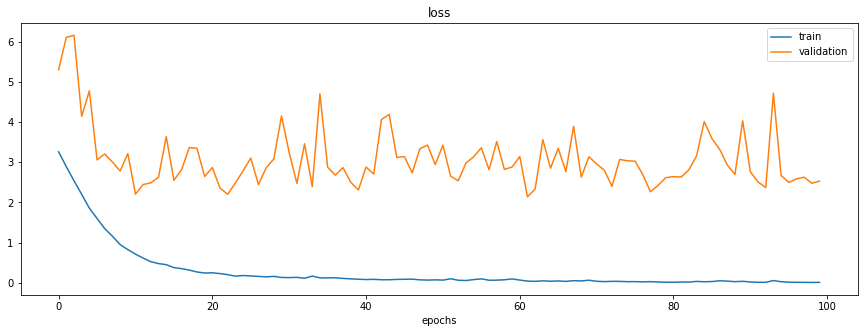

In [38]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()

Text(0.5, 1.0, 'accuracy')

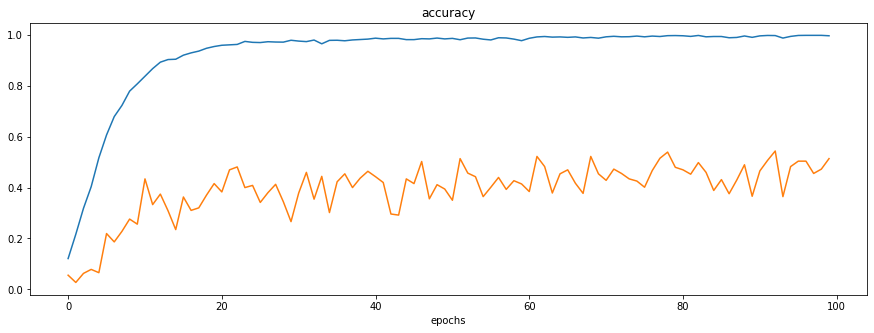

In [39]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.xlabel('epochs')
plt.title('accuracy')

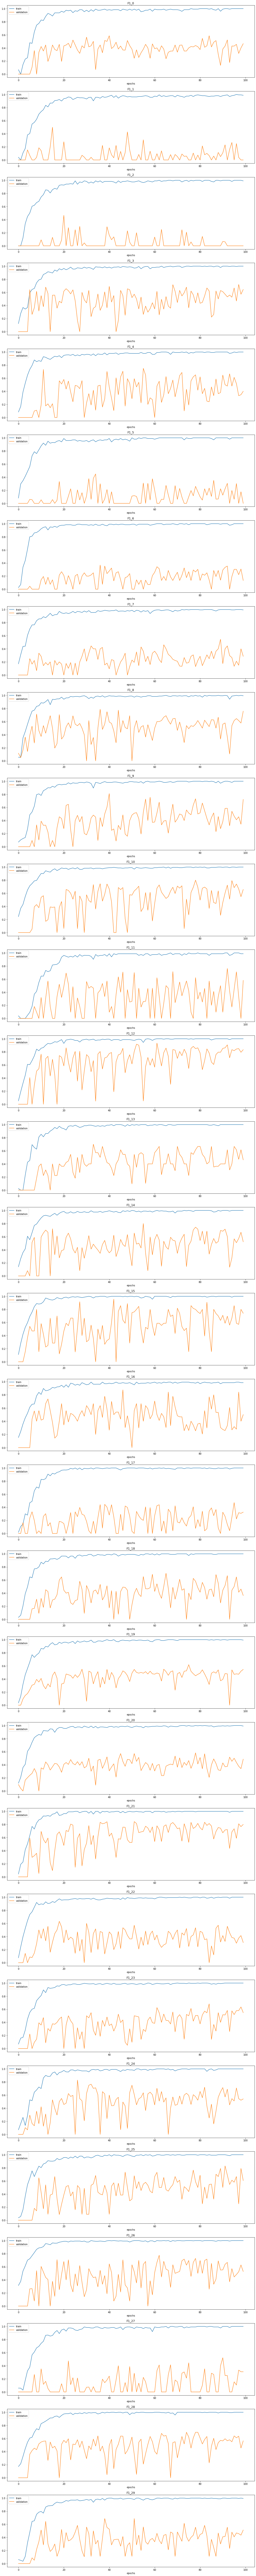

In [41]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history.history['F1_{}'.format(i)],label='train')
    plt.plot(history.history['val_F1_{}'.format(i)],label='validation')
    plt.title('F1_{}'.format(i))
    plt.xlabel('epochs')
    plt.legend()
plt.tight_layout()